In [57]:
import math
from typing import Tuple
from numba import cuda
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float64
import matplotlib.pyplot as plt
from scipy.stats import norm
import timeit
import sobol_seq
from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, metrics
from keras import metrics
from sklearn.model_selection import train_test_split

## generate trainig dataset


In [19]:
def get_value(F0:float,T:float,alpha0:float,beta:float,nu:float,
    rho:float,  K: float, Nstep:int, Ntrace: int)->Tuple[float,float]:




    payoff_holder = np.zeros(Ntrace)
    cu_payoff_holder = cuda.to_device(payoff_holder)

    tpb = 512
    bpg = (Ntrace + (tpb - 1)) // tpb
    rng_states = create_xoroshiro128p_states(tpb * bpg,
                                             seed=np.random.randint(1,10 ** 5))

    cu_get_value[bpg, tpb](F0, T,
                           alpha0, beta, nu, rho, K,
                           Nstep, Ntrace,
                           cu_payoff_holder,
                           rng_states)
    cu_payoff_holder.to_host()

    return float(np.mean(payoff_holder)), np.std(payoff_holder) / np.sqrt(Ntrace)

@cuda.jit
def cu_get_value(F0, T,  alpha0, beta, nu, rho, K, Nstep, Ntrace, payoff_holder,rng_states):

    itrace = cuda.grid(1)  # Index for trace

    F1 = F0
    F2 = F0
    alpha1 = alpha0
    alpha2 = alpha0

    if itrace < Ntrace:
        #if itrace%10==0:
        #    clear_output(wait=True)
        #    print("Trace #" + str(itrace))

        dt = T / Nstep
        #dt_list = math.flip(math.diff(math.geomspace(1e-5, self.T, num=self.Nstep),prepend=[0]))

        for istep in range(Nstep):
            X1 = xoroshiro128p_normal_float64(rng_states, itrace)
            X2 = xoroshiro128p_normal_float64(rng_states, itrace)
            Z=rho*X1+math.sqrt(1.-rho**2.)*X2

            F1 += alpha1*(math.pow(F1,beta))*math.sqrt(dt)*X1
            alpha1 += nu*alpha1*math.sqrt(dt)*Z
            F2 += alpha2*(math.pow(F2,beta))*math.sqrt(dt)*X1*(-1.)
            alpha2 += nu*alpha2*math.sqrt(dt)*Z*(-1.)
        #plt.plot(F1list,'b')

        payoff1 = max(F1 - K,0.)
        payoff2 = max(F2 - K,0.)

        payoff_holder[itrace] = (payoff1 + payoff2)/2.

sampling input with 5D sobol sequence

In [20]:
N = 50000
seq = sobol_seq.i4_sobol_generate(5, N)
alphalist = seq[:,0]
betalist = seq[:,1]
rholist = seq[:,2]*2-1
nulist = seq[:,3]
Tlist = seq[:,4]*11/12+1/12
Klist = np.linspace(0.6,1.8,N)

simulating values with MC and save to file

In [21]:
filename = 'training_data.dat'
Nstep = 10000
Ntrace = 10000
outfile = open(filename,'a')
for i in range(N):
    if i%10==0:
        clear_output(wait=True)
        print("Sample #" + str(i))
    alpha0 = alphalist[i]
    beta = betalist[i]
    rho = rholist[i]
    nu = nulist[i]
    T = Tlist[i]
    K = Klist[i]

    mean_value,std_value = get_value(F0 = 1.0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)

    outfile.write(str(alpha0)+' '+str(beta) + ' '+ str(rho) +' '
                  + str(nu)+ ' ' +str(T)+ ' '+str(K)+ ' '+
                  str(mean_value)+ ' ' + str(std_value) + '\n')

outfile.close()

Sample #49990


## Build Neural Network


In [68]:
# load the dataset
data = np.loadtxt("training_data.dat",delimiter=' ')

# split into input(X) and output (y) variables
X = data[:,0:6]
y = data[:,6]

# split test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.1, random_state=42)

In [69]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [70]:
# define Keras model (from https://hpcquantlib.wordpress.com/2019/10/12/almost-exact-sabr-interpolation-using-neural-networks-and-gradient-boosted-trees/)
model = Sequential()
model.add(Dense(20, activation='linear', input_shape=(6, )))
model.add(Dense(100, activation='linear'))
model.add(Dense(400, activation='sigmoid'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))


In [71]:
# compile the model
opt = optimizers.Adam(learning_rate=0.01)
m = metrics.MeanSquaredError()
model.compile(loss='mae', optimizer=opt,metrics=[m])
# fit the model
model.fit(X_scaled, y_train, epochs=150, batch_size=50)

Epoch 1/150
45000/45000 [==============================] - 1s 22us/step - loss: 0.0417 - mean_squared_error: 0.0041

In [72]:
#evaluate the model
loss, mse = model.evaluate(scaler.transform(X_test), y_test, verbose=0)
print('MSE: %.9f' % (mse))

MSE: 0.000062477


In [106]:
def bs_call(K:float, F0:float, T:float, vol:float)->float:
      d1 = (np.log(F0/K) + (0.5*vol**2)*T) / (vol*np.sqrt(T))
      d2 = d1 - vol * np.sqrt(T)
      return F0 * norm.cdf(d1) -  K*norm.cdf(d2)
def bs_vega(K:float, F0:float, T:float, vol:float):
      d1 = (np.log(F0 / K) + (0.5 * vol ** 2) * T) / (vol* np.sqrt(T))
      return F0 * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value:float, F0:float , K:float, T:float):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-6
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(K=K, F0=F0, T=T, vol=sigma)
        vega = bs_vega(K=K, F0=F0, T=T, vol=sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma

Text(0, 0.5, 'vol')

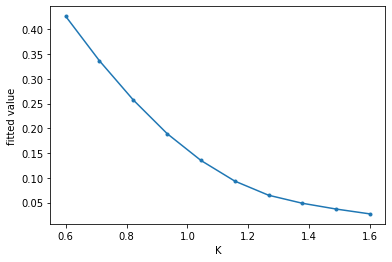

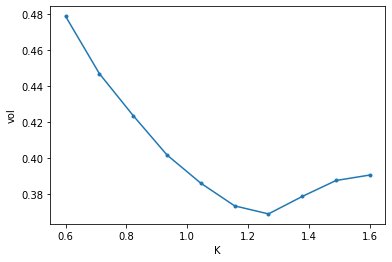

In [105]:
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
Klist = np.linspace(0.6,1.6,10)
Vlist = []
vol_list = []
for K in Klist:
    input = np.array([alpha0,beta,rho,nu,T,K]).reshape(1, -1)
    value = model.predict(scaler.transform(input))[0][0]
    vol = find_vol(target_value=value, F0=1.0 , K=K, T=T)
    Vlist.append(value)
    vol_list.append(vol)

plt.figure()
plt.plot(Klist,Vlist,'.-')
plt.xlabel('K')
plt.ylabel('fitted value')
plt.figure()
plt.plot(Klist,vol_list,'.-')
plt.xlabel('K')
plt.ylabel('vol')

$\rho$ Dynamics


rho = -0.25
rho = 0.0
rho = 0.25


Text(0, 0.5, 'implied volatility')

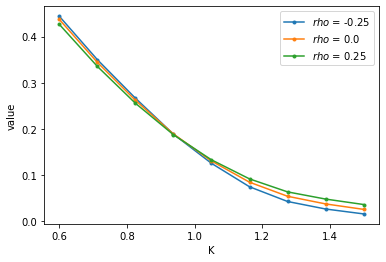

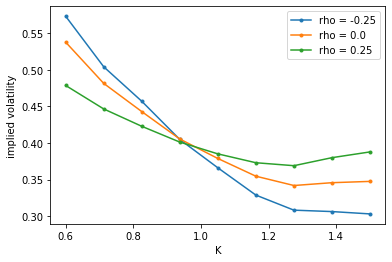

In [104]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0


rholist = np.linspace(-0.25,0.25,3)
Klist = np.linspace(0.6,1.5,9)
vol_record3 = []
val_record3 = []
for rho in rholist:
    print('rho = ' + str(rho))
    vol_list = []
    val_list = []
    for K in Klist:
        input = np.array([alpha0,beta,rho,nu,T,K]).reshape(1, -1)
        value = model.predict(scaler.transform(input))[0][0]
        vol = find_vol(target_value = value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    rho = rholist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "$rho$ = "+str(rho))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    rho = rholist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "rho = "+str(rho))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')
